<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20230922_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습과 랜덤 포레스트

앙상블: 여러 개의 예측기로부터 예측을 수집
>
랜덤 포레스트: 결정 트리의 앙상블

**7.1 투표 기반 분류기**

* 직접 투표 분류기: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
* 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 앙상블한 것의 예측력이 더 좋은 경우가 많음
* 약한 학습기라도 충분히 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음. (큰 수의 법칙 때문)

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [3]:
# 투표 기반 분류기를 만들어 훈련시키는 코드(VotingClassifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [12]:
# 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.9
SVC 0.95
VotingClassifier 0.95


-> 투표 기반 분류기가 개별 분류기보다 성능이 더 높음

* 확률이 높은 투표에 더 비중을 두는 간접 투표 방식도 존재 (voting='soft')

**7.2 배깅과 페이스팅**

* 배깅: 같은 훈련 세트에서 중복을 허용하여 샘플링하는 방식
* 페이스팅: 중복을 허락하지 않고 샘플링
* 모든 예측기가 훈련을 마치면 예측치들을 모아서 새로운 샘플에 대한 예측을 만듦 -> 분류: 최빈값, 회귀: 평균

7.2.1 사이킷런의 배깅과 페이스팅

In [13]:
# 결정 트리 분류기 500개의 앙상블 훈련
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

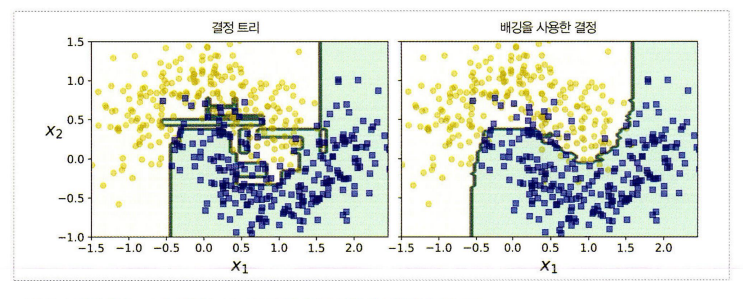

* 단일 결정 트리와 트리를 사용한 배깅 앙상블의 결정 경계를 비교했을 때, 앙상블의 예측의 일반화가 훨씬 잘 됨

7.22 oob 평가

* BaggingClassifier는 기본값으로 중복을 허용하여 샘플 선택 -> 선택되지 않은 훈련 샘플이 생길 수 있음(=oob 샘플)
* 예측기가 훈련되는 동안 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 이용해 평가할 수 있음
* oob_score = True로 지정하면 훈련 후 알아서 oob 평가를 수행하고 oob_score_ 변수에 평가 점수 결과가 저장됨

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.95

In [15]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.95

-> oob 평가 결과를 통해 테스트 세트에서 95% 정도의 정확도를 예상했는데 역시 같았음

* oob 샘플에 대한 결정 함수 값: oob_decision_function_으로 확인

In [16]:
bag_clf.oob_decision_function_

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.99408284, 0.00591716],
       [0.87362637, 0.12637363],
       [0.18131868, 0.81868132],
       [0.70520231, 0.29479769],
       [1.        , 0.        ],
       [0.2967033 , 0.7032967 ],
       [0.02116402, 0.97883598],
       [0.01092896, 0.98907104],
       [0.12865497, 0.87134503],
       [0.95675676, 0.04324324],
       [1.        , 0.        ],
       [0.02339181, 0.97660819],
       [0.01546392, 0.98453608],
       [0.        , 1.        ],
       [0.01030928, 0.98969072],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.34782609, 0.65217391],
       [0.04571429, 0.95428571],
       [0.23979592, 0.76020408],
       [0.00588235, 0.99411765],
       [0.01546392, 0.98453608],
       [0.72881356, 0.27118644],
       [0.        , 1.        ],
       [0.69346734, 0.30653266],
       [0.5       , 0.5       ],
       [0.03174603, 0.96825397],
       [1.        , 0.        ],
       [0.

7.3 랜덤 패치와 랜덤 서브스페이스

* 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
* 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용(bootstrap=False, max_samples=1.0)하고 특성을 샘플링 하는 것(bootstrap_features=True)

**7.4 랜덤 포레스트**
* BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어있는 RandomForestClassifier를 사용할 수 있음

In [17]:
# 500개 트리로 이루어진 랜덤포레스트 분류기 훈련
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

* 랜덤 포레스트 알고리즘은 무작위성을 더 주입하므로 분산을 낮추어 더 훌륭한 모델을 만들어냄

In [18]:
# BaggingClassifier를 사용해 RandomForestClassifier와 유사하게 만듦
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

7.4.1 엑스트라 트리

* 랜덤 포레스트에서는 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음, 그 중 최상의 분할을 선택
* 익스트림 랜덤 트리: 극단적으로 무작위한 트리(편향은 늘지만 분산은 줄어듦)
* ExtraTreesClassifier나 ExtraTreesRegressor 사용(랜덤포레스트보다 성능이 더 좋은지 예단하기는 어려움)



7.4.2 특성 중요도

* 랜덤포레스트는 특성의 상대적 중요도를 측정하기 쉬움
* 모든 트리에 걸쳐 평균적으로 불순도를 얼마나 감소시키는지 확인해 특성의 중요도 측정

In [19]:
# RandomForestClassifier를 훈련시키고 특성의 중요도를 출력함
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10273197052511931
sepal width (cm) 0.022909185599272477
petal length (cm) 0.43113582468929623
petal width (cm) 0.4432230191863119


-> 꽃잎의 길이와 너비가 꽃받침의 길이와 너비에 비해 훨씬 중요해보임

**7.5 부스팅**

* 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법으로, 앞의 모델을 보완해나가며 일련의 예측기 학습시킴

7.5.1 에이다부스트
* 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 새로운 예측기가 학습하기 어려운 샘플에 더 맞춰질 수 있게 해줌.
* 샘플의 가중치를 업데이트하면서 순차적으로 학습시킴

* 에러율(r) 계산 후, 예측기 가중치(alpha=lr*log((1-r)/r) 계산
* 잘못 분류된 샘플의 가중치를 증가(w*exp(alpha))시킨 후 가중치를 정규화함(w의 합으로 나누기)
* 가중치로 훈련시키고 업데이트를 반복

* 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 alpha를 더해 예측 결과를 만듦 -> 가중치 합이 가장 큰 클래스가 예측 결과가 됨

* 사이킷런은 SAMME 버전을 이용, 예측기가 클래스의 확률을 추정할 수 있다면(predict_proba()) SAMME.R을 사용

In [20]:
# AdaBoostClassifier를 사용해 200개의 얕은 결정 트리를 기반으로 하는 분류기 훈련
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

7.5.2 그레디언트 부스팅

* 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는데, 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [21]:
# DecisionTreeRegressor를 훈련 세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [22]:
# 첫 번째 예측기에서 생긴 잔여 오차에 모델 다시 훈련
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [23]:
# 두 번째 예측기에서 생긴 잔여 오차에 모델 다시 훈련
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 모든 트리의 예측을 더해 새로운 샘플에 대한 예측 만들기
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

* 트리가 앙상블에 추가될수록 앙상블의 예측이 점점 좋아짐

* 사이킷런의 GradientBoostingRegressor를 사용해 훈련

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

* 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있음 -> staged_predict()
* GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정, 최적의 트리 수를 이용해 새로운 GBRT 앙상블 훈련

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=101)

In [27]:
# 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up=0
  else:
    error_going_up += 1
    if error_going_up ==5:
      break

* subsample=0.25는 무작위로 선택된 25%의 훈련 샘플로 학습 -> 분산이 낮아지고 훈련 속도를 상당히 높임 = 확률적 그레디언트 부스팅

* XGBoost: extreme gradient boosting

In [28]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [29]:
# 자동 조기 종료 등의 기능 제공
xgb_reg.fit(X_train, y_train, eval_set =[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.39062
[1]	validation_0-rmse:0.33878
[2]	validation_0-rmse:0.28728
[3]	validation_0-rmse:0.25695
[4]	validation_0-rmse:0.23996
[5]	validation_0-rmse:0.23045
[6]	validation_0-rmse:0.22561
[7]	validation_0-rmse:0.22312
[8]	validation_0-rmse:0.22176
[9]	validation_0-rmse:0.22090
[10]	validation_0-rmse:0.22075
[11]	validation_0-rmse:0.22108


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


**7.6 스태킹**

* 모든 예측기로부터 예측하고 마지막 예측기인 메타학습기가 이 값을 받아 최종 예측을 만듦
* 홀드 아웃 세트 사용-> 메타학습기를 학습시키는 일반적인 방법

1) 훈련 세트를 두 개의 서브셋으로 나누기
>
2) 첫 번째 서브셋에 대해 예측기를 사용해 두 번째 세트에 대한 예측을 만듦
>
3) 첫 번째 예측값이 3개가 있으므로 새로운 훈련 세트는 3차원이 되고, 이를 이용해 두 번째 세트에 대한 타깃값을 예측
>
4) 그렇게 만들어진 훈련 세트를 블렌딩하기
>
5) 메타학습기를 통해 최종 예측

* 직접 구현해야함